In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.transforms as T

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)



In [3]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [4]:
class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.down1 = self.UnetDoubleConv(3,64)
        self.down2 = self.UnetDoubleConv(64,128)
        self.down3 = self.UnetDoubleConv(128,256)
        self.down4 = self.UnetDoubleConv(256,512)
        self.down5 = self.UnetDoubleConv(512,1024)
        
        self.up1 = self.UnetDoubleConv(64,82)
        self.up2 = self.UnetDoubleConv(128,64)
        self.up3 = self.UnetDoubleConv(256,128)
        self.up4 = self.UnetDoubleConv(512,256)
        self.up5 = self.UnetDoubleConv(1024,512)
        
        self.upConvT2 = self.UnetUpConv(128,64)
        self.upConvT3 = self.UnetUpConv(256,128)
        self.upConvT4 = self.UnetUpConv(512,256)
        self.upConvT5 = self.UnetUpConv(1024,512)

        self.softmax = torch.nn.Softmax(dim=1)

        self.final = nn.Conv2d(82,82,1,padding='same')

        
    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def UnetUpConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
            
    
    def forward(self,x):
        convOut1 = self.down1(x)
        maxPool1 = nn.MaxPool2d(2)(convOut1)
        convOut2 = self.down2(maxPool1)
        maxPool2 = nn.MaxPool2d(2)(convOut2)
        convOut3 = self.down3(maxPool2)

        upPool3 = self.upConvT3(convOut3)
        upPool3Cat = torch.cat([upPool3,convOut2],dim=1)
        incConvOut2 = self.up3(upPool3Cat)
        upPool2 = self.upConvT2(incConvOut2)
        upPool2Cat = torch.cat([upPool2,convOut1],dim=1)
        incConvOut1 = self.up2(upPool2Cat)
        
        out1 = self.up1(incConvOut1)
        out = self.final(out1)
        
        return(out)
        


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import copy
from torch.utils.data import Dataset, DataLoader
import math

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [6]:
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"

In [7]:
def get_split_files(split_name):
    with open(split_dir + f"/{split_name}.txt", 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [8]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

In [9]:
# from torchsummary import summary
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet().to(DEVICE)
# summary(model, (3,180,320))

In [10]:
# hyper parameters

IMAGE_HEIGHT = 360
IMAGE_WIDTH = 640

num_epochs = 4
batch_size = 4
learning_rate = 0.004

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, term = 'train', transform=None):
        self.term = term 
        rgb_files, depth_files, label_files, meta_files = get_split_files(self.term)
        self.image_dir = rgb_files
        self.mask_dir = label_files
        self.transform = transform
        

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, index):
        
        image = np.array(Image.open(self.image_dir[index])) / 255
        mask = np.array(Image.open(self.mask_dir[index]))
        
#         image = image[::4, ::4]
#         mask = mask[::4, ::4]

        image = image[::2, ::2]
        mask = mask[::2, ::2]
        
        image = torch.from_numpy(image.astype(np.float32))
        mask = torch.from_numpy(mask.astype(np.int64))
        
        
        return image, mask

In [12]:
dataset = SegmentationDataset()

dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 0, drop_last = True)

# Next 4 lines are just to see the data for batch_size = 4 and NOT a part of pipeline

dataiter = iter(dataloader)
data = dataiter.next()
imgs, edgs = data
print(imgs.shape, edgs.shape)

torch.Size([4, 360, 640, 3]) torch.Size([4, 360, 640])


In [13]:
# model = UNET(in_channels=3, out_channels=82)
model = Unet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [14]:
# Training loop
n_total_steps = len(dataloader)   # n_total_steps = total num samples in dataset / batch_size

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        
        images = images.permute(0,3,1,2).to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Gradients
        optimizer.zero_grad()
        loss.backward()
        
        # Weights update
        optimizer.step()
        
        if (i+1) %100 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss}')

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 1/4, step 100/991, loss = 0.07830260694026947
epoch: 1/4, step 200/991, loss = 0.0263142678886652
epoch: 1/4, step 300/991, loss = 0.03468532860279083
epoch: 1/4, step 400/991, loss = 0.012632087804377079
epoch: 1/4, step 500/991, loss = 0.01122840866446495
epoch: 1/4, step 600/991, loss = 0.004282912705093622
epoch: 1/4, step 700/991, loss = 0.007443442475050688
epoch: 1/4, step 800/991, loss = 0.00900236051529646
epoch: 1/4, step 900/991, loss = 0.0065783062018454075
epoch: 2/4, step 100/991, loss = 0.004144703503698111
epoch: 2/4, step 200/991, loss = 0.004371971357613802
epoch: 2/4, step 300/991, loss = 0.00436217337846756
epoch: 2/4, step 400/991, loss = 0.00219906703568995
epoch: 2/4, step 500/991, loss = 0.0042278035543859005
epoch: 2/4, step 600/991, loss = 0.006598290987312794
epoch: 2/4, step 700/991, loss = 0.00427057221531868
epoch: 2/4, step 800/991, loss = 0.005866166669875383
epoch: 2/4, step 900/991, loss = 0.0018818490207195282
epoch: 3/4, step 100/991, loss = 0

In [15]:
PATH = './segmentation_model_halfsize.pth'
torch.save(model.state_dict(), PATH)

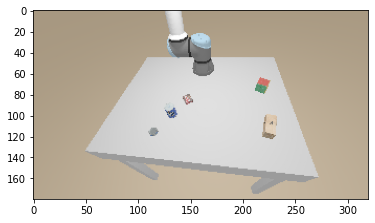

In [196]:
plt.imshow(np.transpose(images.cpu().detach().numpy()[0],(1,2,0)))

In [197]:
dataiter = iter(dataset)
d = next(dataiter)
image, label = d

In [198]:
d = next(dataiter)
image, label = d

In [199]:
torch.unsqueeze(image.permute(2,0,1),0).shape

torch.Size([1, 3, 180, 320])

In [202]:
image.shape

torch.Size([180, 320, 3])

In [200]:
dis_label = np.argmax(torch.squeeze(model(torch.unsqueeze(image.permute(2,0,1),0).to(DEVICE)),0).cpu().detach().numpy(),0)

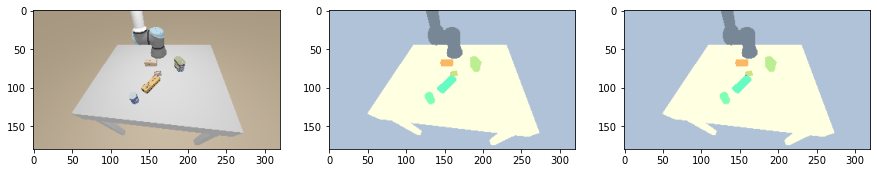

In [201]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(COLOR_PALETTE[label])
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[dis_label])  # draw colorful segmentation

In [194]:
PATH = './segmentation_model1.pth.tar'
torch.save(model.state_dict(), PATH)

In [195]:
PATH = './segmentation_model1.pth'
torch.save(model.state_dict(), PATH)